In [9]:
# import huggingface datasets: https://huggingface.co/datasets/Matthijs/snacks
from datasets import load_dataset

In [10]:
snacks = load_dataset("Matthijs/snacks")
snacks

Found cached dataset snacks (/Users/kaiding/.cache/huggingface/datasets/Matthijs___snacks/default/0.0.1/c0ce49075aa469a098a5f2e3455941c894e02e1c9bf642d4d33e6c51460ff590)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4838
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 952
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 955
    })
})

In [11]:
train_snacks = snacks["train"]
train_snacks

Dataset({
    features: ['image', 'label'],
    num_rows: 4838
})

In [12]:
train_snacks[:5]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x341 at 0x7FBF822D9DC0>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=341x256 at 0x7FBF833CE580>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x256 at 0x7FBF833CE8E0>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=341x256 at 0x7FBF822D0040>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=341x256 at 0x7FBF833FB7F0>],
 'label': [0, 0, 0, 0, 0]}

In [13]:
from PIL import Image
import matplotlib.pyplot as plt

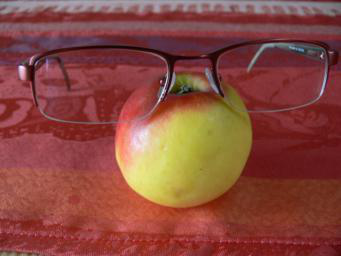

In [14]:
train_snacks[0]["image"]
train_snacks[1]["image"]

In [16]:
#pre-processing
from skimage.transform import resize
import numpy as np

# resize all image to 224x224
processed_img = []
for i in range(len(train_snacks)):
    img_array = np.array(train_snacks[i]["image"], dtype=np.float32) / 255  
    #print("img_array.shape:", img_array.shape)
    img_resized = resize(img_array, (224, 224), anti_aliasing=True)
    #print("img_resized.shape:", img_resized.shape)  
    processed_img.append(img_resized)

In [17]:
processed_img[1].shape

(224, 224, 3)

In [18]:
# Feature 1 - HSV by hue/saturation/value
from skimage.color import rgb2hsv

hue_hist_class = {}
saturation_hist_class = {}
value_hist_class = {}
for i in range(len(processed_img)):
    image = processed_img[i]
    label = train_snacks[i]["label"]

    # hsv conversion
    hsv_img = rgb2hsv(image)
    hue_img = hsv_img[:, :, 0]
    saturation_img = hsv_img[:, :, 1]
    value_img = hsv_img[:, :, 2]

    # histogram
    hue_hist = np.histogram(hue_img, bins=20, range=(0, 1))[0]
    hue_hist = hue_hist / np.sum(hue_hist)
    saturation_hist = np.histogram(saturation_img, bins=20, range=(0, 1))[0]
    saturation_hist = saturation_hist / np.sum(saturation_hist)
    value_hist = np.histogram(value_img, bins=20, range=(0, 1))[0]
    value_hist = value_hist / np.sum(value_hist)

    # add to dict
    if label not in hue_hist_class:
        hue_hist_class[label] = []
    hue_hist_class[label].append(hue_hist)
    if label not in saturation_hist_class:
        saturation_hist_class[label] = []
    saturation_hist_class[label].append(saturation_hist)
    if label not in value_hist_class:
        value_hist_class[label] = []
    value_hist_class[label].append(value_hist)

# get average for each class
for label in hue_hist_class:
    hue_hist_class[label] = np.mean(hue_hist_class[label], axis=0)
for label in saturation_hist_class:
    saturation_hist_class[label] = np.mean(saturation_hist_class[label], axis=0)
for label in value_hist_class:
    value_hist_class[label] = np.mean(value_hist_class[label], axis=0)

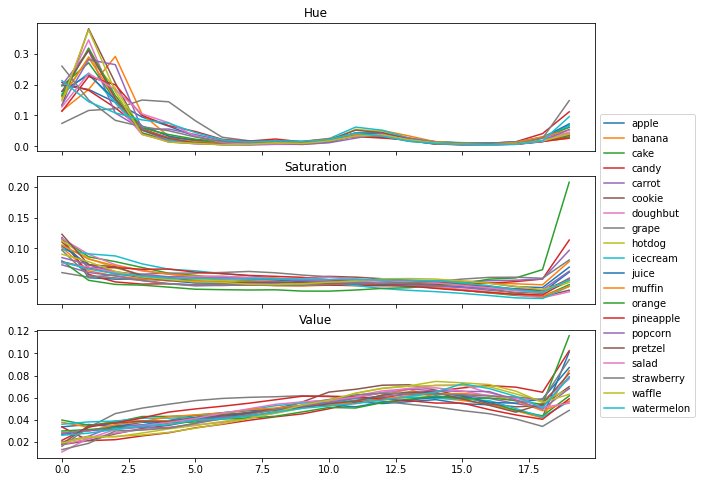

In [63]:
# visualize the histograms 
# Hue channel looks the most useful
import matplotlib.pyplot as plt

# map label to vocab
label_vocab = {0: "apple",1:"banana",2:"cake",3:"candy",4:"carrot",5:"cookie",6:"doughbut",
7:"grape",8:"hotdog",9:"icecream",10:"juice",11:"muffin",12:"orange",13:"pineapple",14:"popcorn",
15:"pretzel",16:"salad",17:"strawberry",18:"waffle",19:"watermelon"}

# show bar plots in subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for label in hue_hist_class:
    axs[0].plot(hue_hist_class[label], label=label_vocab[label])
for label in saturation_hist_class:
    axs[1].plot(saturation_hist_class[label], label=label_vocab[label])
for label in value_hist_class:
    axs[2].plot(value_hist_class[label], label=label_vocab[label])
axs[0].set_title("Hue")
axs[1].set_title("Saturation")
axs[2].set_title("Value")
axs[2].legend(loc='center left', bbox_to_anchor=(1, 1.5))
plt.show()


In [32]:
# Feature 2 - HOG
# preprocess - resize images to 64*128 and change to greyscale

from skimage import color
from skimage.feature import hog

processed_img_hog = []
for i in range(len(train_snacks)):
    img_array = np.array(color.rgb2gray(train_snacks[i]["image"]), dtype=np.float32) / 255  
    #print("img_array.shape:", img_array.shape)
    img_resized = resize(img_array, (128,64), anti_aliasing=True)
    #print("img_resized.shape:", img_resized.shape)  
    processed_img_hog.append(img_resized)

print(processed_img_hog[1].shape)

(128, 64)


In [43]:
# compute hog greyscale
# tried pixels_per_cell = (16,16), but (8,8) seems to have much better results
fds = []
hog_images = []
for i in range(len(processed_img_hog)):
    fd, hog_image = hog(processed_img_hog[i], orientations=8, \
        pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True)
    fds.append(fd)
    hog_images.append(hog_image)

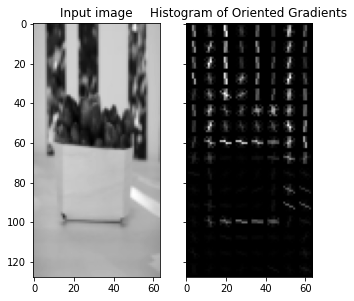

In [53]:
# visualize one image and its hog descriptor
from skimage import exposure

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5), sharex=True, sharey=True)

ax1.imshow(processed_img_hog[5], cmap=plt.cm.gray)
ax1.set_title('Input image')

# rescale hog for better display
hog_image_rescaled = exposure.rescale_intensity(hog_images[5], in_range=(0, 10))
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()